# `shapely`对矢量数据的处理(3) 空间分析

In [1]:
import shapely; 
import shapely.geometry as shplgeo, shapely.affinity as shplaffin; 
import shapely.ops as shplops; 
import pyproj

In [2]:
#定义三角形ΔABC, 其中∠C是直角
vertex_coord = ((1, 0), (0, 1), (0, 0)); 
A, B, C = tuple(shplgeo.Point(x, y) for x, y in vertex_coord); 
verteces = shplgeo.multipoint.MultiPoint(vertex_coord); 
triangleABC = shplgeo.Polygon(verteces); 
print(triangleABC); 

POLYGON ((1 0, 0 1, 0 0, 1 0))


In [3]:
#分别构造ΔABC,的外接矩形, 最小外接矩形, 最小外接凸多边形
triangleABC_Envl = triangleABC.envelope; 
triangleABC_RotEnvl = triangleABC.minimum_rotated_rectangle; 
triangleABC_Convex = triangleABC.convex_hull; 

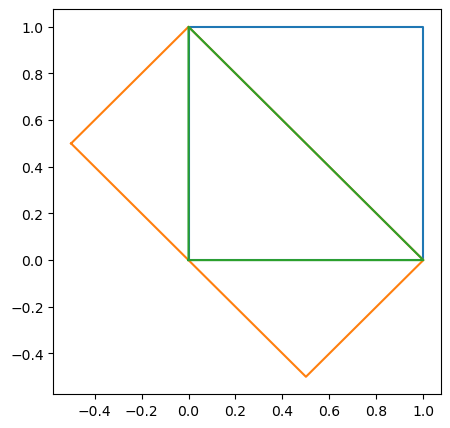

In [4]:
#绘图比较三种外接多边形的范围
import matplotlib.pyplot as plt; 
plt.subplots(figsize=(5, 5)); 
for polygon in [triangleABC_Envl, triangleABC_RotEnvl, triangleABC_Convex]: 
    x, y = polygon.boundary.xy; 
    plt.plot(x, y); 
plt.show(); 

## 叠置分析
|方法名称|功能|备注|
|:-|:-:|:-|
|`shp1.union(shp2)`|`shp1`与`shp2`的并集|如对三个以上图形求并集, 推荐使用<br>`shapely.ops.unary_union`函数|
|`shp1.inersection(shp2)`|`shp1`与`shp2`的交集||
|`shp1.difference(shp2)`|`shp1`与`shp2`的差集||
|`shp1.symmertric_`<br>`difference(shp2)`|`shp1`与`shp2`的对称差|等效于$(S_1 \bigcup S_2) \setminus (S_1 \bigcap S_2)$|

叠置分析永远返回**新的图形, 不改变**参与运算的`shp1`和`sbp2`

True


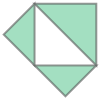

In [5]:
#对称差可以通过并, 交和差表示
geom_un_int_diff = triangleABC_Envl.union(triangleABC_RotEnvl).difference(
    triangleABC_Envl.intersection(triangleABC_RotEnvl)
); 
geom_symdiff = triangleABC_Envl.symmetric_difference(triangleABC_RotEnvl); 
print(geom_un_int_diff.equals(geom_symdiff)); 
geom_symdiff

## 缓冲区分析及其衍生方法
|方法名称|功能|备注|
|:-|:-:|:-|
|`shp.buffer(`<br>`dist, single_sided=SIDE`<br>`cap_style=CAP, join_style=JOIN, `<br>`resolution=RES, mitre_limit=LIM)`|在`shp`覆盖范围的<br>周边, 以`dist`为最大<br>距离构建缓冲区|`SIDE`指定是否构建单侧缓冲区<br>若指定为`True`, 则`dist>0`时构造沿折线<br>或多边形边界行进方向右侧的缓冲区, 反之<br>构造左侧缓冲区. (默认为`False`)<br>`CAP`, `JOIN`指定端点和转折处缓冲区边界<br>的形状, 包括`1`(圆形, 默认值), `2`(平头), <br>`3`(方形)等类型<br>`RES`指定几何对象每个端点所对应的, 缓冲区<br>边界的采样点数目<br>`LIM`指定锐角转弯处端点外侧的缓冲区边界<br>被截断的阈值|
|`shp.parallel_offset(`<br>`dist, side=SIDE, `<br>`join_style=JOIN, `<br>`resolution=RES, mitre_limit=LIM)`|在**线状**`shp`周边, 以<br>`dist`为距离构建缓冲<br>区的单侧边界|`SIDE`指定缓冲区边界相对于`shp`行进方向<br>的方位, 包括`right`(右侧, 默认值)和`left`<br>(左侧)||
|`shapely.ops.polylabel`|求解**多边形**`shp`的难抵极|多边形内部到其边界距离最大的点|

In [6]:
#构造ΔABC外侧0.5单位长度的缓冲区
triangleABC_buff = triangleABC.boundary.buffer(0.5).difference(triangleABC); 
#构造五边形外侧0.5单位长度的缓冲区边界
geom_un = triangleABC_Envl.union(triangleABC_RotEnvl); 
geom_un_off_ext = geom_un.exterior.parallel_offset(0.5, 
    side = ("right" if geom_un.exterior.is_ccw else "left")
); 

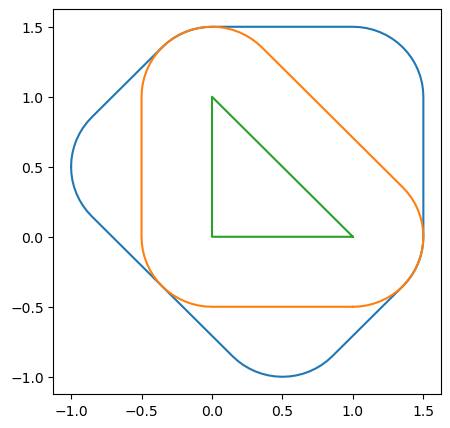

In [7]:
#绘图两种缓冲范围
import matplotlib.pyplot as plt; 
plt.subplots(figsize=(5, 5)); 
for pline in [geom_un_off_ext, triangleABC_buff.exterior, 
    triangleABC_buff.interiors[0]]: 
    x, y = pline.xy; 
    plt.plot(x, y); 
plt.show(); 

In [8]:
#三角形的难抵极恰为其重心
triangleABC_Inner_Center = shplops.polylabel(triangleABC); 
print(triangleABC_Inner_Center); 

POINT (0.3333333333333333 0.3333333333333333)


## 路径几何分析
|方法名称|功能|备注|
|:-|:-:|:-|
|`shp1.interpolate(pos, `<br>`normalized=NC)`|计算折线`shp1`上从起点出发, <br>沿折线路径行进`pos`所得的点|`NC`指定`pos`是否对折线全长<br>进行正规化处理. <br>若指定为`True`, 则行进路程长度<br>为`pos * shp1.length`|
|`shp1.interpolate(pos1, pos2, `<br>`normalized=NC)`|调整折线的起终点, 使二者<br>分别位于原折线内, 从而构造新的折线|新的起, 终点分别从原折线`shp1`上<br>起点出发, 沿折线路径行进`pos1`, <br>`pos2`所得的点. <br>`NC`指定`pos`是否对折线全长<br>进行正规化处理. <br>若指定为`True`, 则行进路程长度<br>为`pos * shp1.length`|

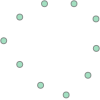

In [9]:
#生成闭合曲线的十等分点
import numpy as np; 
geom_un_off_prtn = shplgeo.MultiPoint(tuple(
    geom_un_off_ext.interpolate(
        pos, normalized=True
    ) for pos in np.arange(0, 1, 0.1)
) )
geom_un_off_prtn

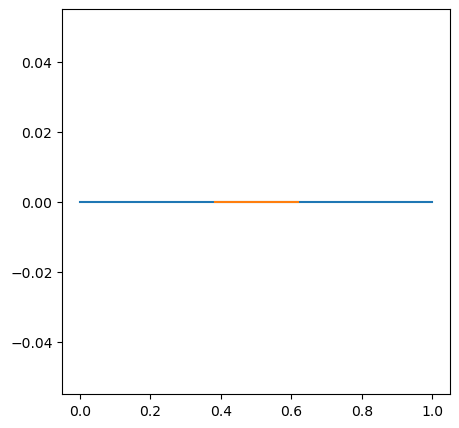

In [10]:
#构造ΔABC的边AC上的两个黄金分割点
edge_CA = shplgeo.LineString([C, A]); 
golden_ratio = (np.sqrt(5) - 1) / 2; 
#利用上述两点截断边AC
edge_CA_subseg = shplops.substring(edge_CA, 
    1 - golden_ratio, golden_ratio, normalized=True
); 
import matplotlib.pyplot as plt; 
plt.subplots(figsize=(5, 5)); 
for pline in [edge_CA, edge_CA_subseg]: 
    x, y = pline.xy; 
    plt.plot(x, y); 
plt.show(); 